In [10]:
%load_ext autoreload
%autoreload 2
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('MNRAS')
from scipy import linalg
from scipy.interpolate import interp1d

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [13]:
## make the fake data
rich_name = 'q180_bg_miscen'

lam = [20, 30, 45, 60, 1000]
z_data = [0.2, 0.35, 0.5, 0.65]
z_sim = [0.3, 0.4, 0.5]

iz = 0
#binning = 'lam' # 'abun'

#for iz in [0]:#range(3):
for binning in ['lam', 'abun']:

    redshift = z_sim[iz]   
    if redshift == 0.3: z_str = '0p300'
    if redshift == 0.4: z_str = '0p400'
    if redshift == 0.5: z_str = '0p500'
    
    data_loc = '/projects/hywu/cluster_sims/cluster_finding/data/emulator_data/base_c000_ph000/'
    data_loc += f'z{z_str}/model_hod000000/obs_{rich_name}_desy1/'
    # get the radius
    rp_list = np.logspace(np.log10(0.03), np.log10(30), 15+1)
    rpmin_list = rp_list[:-1]
    rpmax_list = rp_list[1:]
    rpmid_list = np.sqrt(rpmin_list*rpmax_list)
    rp_rad = rpmid_list[rpmid_list>0.2]
    
    #### lesing data ####
    DS_data = []
    for ilam in range(4):
        rp_in, DS_in = np.loadtxt(data_loc + f'DS_phys_noh_{binning}_bin_{ilam}.dat', unpack=True)
        DS_interp = interp1d(np.log(rp_in), np.log(DS_in))
        DS_data.extend(np.exp(DS_interp(np.log(rp_rad))))
    DS_data = np.array(DS_data)
    
    #### lensing cov ####
    cov_loc = '/users/hywu/work/cluster-lensing-cov-public/examples/abacus_summit_analytic/'
    for ilam in range(4):    
        rp_cov = np.loadtxt(cov_loc + f'rp_phys_noh_{z_data[iz]}_{z_data[iz+1]}_{lam[ilam]}_{lam[ilam+1]}.dat')
        
        print('check radius difference', '%.2g'%max(abs(rp_cov[4:]/rp_rad - 1)))
        print(rp_cov[4:])
        print(rp_rad)
        
        data = np.loadtxt(cov_loc + f'DeltaSigma_cov_combined_phys_noh_{z_data[iz]}_{z_data[iz+1]}_{lam[ilam]}_{lam[ilam+1]}.dat')
        data = data[4:,4:]
        if ilam == 0:
            cov_DS = data * 1.
        else:
            cov_DS = linalg.block_diag(cov_DS, data)
    print('np.shape(cov_DS)', np.shape(cov_DS))
    cov_DS_inv = linalg.inv(cov_DS)
    
    if binning == 'lam':
        #### counts data ####
        x, x, NC_data = np.loadtxt(data_loc+'abundance.dat',unpack=True)
        
        #### counts cov ####
        cov_NC = []
        for ilam in range(4):    
            counts, sv, bias, lnM_mean = np.loadtxt(cov_loc + f'counts_{z_data[iz]}_{z_data[iz+1]}_{lam[ilam]}_{lam[ilam+1]}.dat')
            cov_NC.append(counts + sv)
        cov_NC = np.diag(cov_NC)
        cov_NC_inv = linalg.inv(cov_NC)
        
        
        #### combine counts and lensing 
        data_vec = np.append(NC_data, DS_data)
        from scipy.linalg import block_diag
        cov = block_diag(cov_NC, cov_DS)
        cov_inv = block_diag(cov_NC_inv, cov_DS_inv)
        
        print('np.shape(cov_inv)', np.shape(cov_inv))

    if binning == 'abun':
        data_vec = DS_data
        cov = cov_DS
        cov_inv = cov_DS_inv
    
    np.savetxt(f'data_vector_abacus_summit/data_vector_{rich_name}_{binning}_z{redshift}.dat', data_vec)
    np.savetxt(f'data_vector_abacus_summit/cov_inv_z{redshift}.dat', cov_inv)
    np.savetxt(f'data_vector_abacus_summit/cov_z{redshift}.dat', cov)

check radius difference 0.062
[ 0.25319212  0.40128248  0.63598986  1.007976    1.59753431  2.53192125
  4.01282475  6.35989863 10.07976004 15.97534307 25.31921248]
[ 0.23829847  0.37767762  0.59857869  0.9486833   1.5035617   2.3829847
  3.77677624  5.98578694  9.48683298 15.03561701 23.82984704]
check radius difference 0.062
[ 0.25319212  0.40128248  0.63598986  1.007976    1.59753431  2.53192125
  4.01282475  6.35989863 10.07976004 15.97534307 25.31921248]
[ 0.23829847  0.37767762  0.59857869  0.9486833   1.5035617   2.3829847
  3.77677624  5.98578694  9.48683298 15.03561701 23.82984704]
check radius difference 0.062
[ 0.25319212  0.40128248  0.63598986  1.007976    1.59753431  2.53192125
  4.01282475  6.35989863 10.07976004 15.97534307 25.31921248]
[ 0.23829847  0.37767762  0.59857869  0.9486833   1.5035617   2.3829847
  3.77677624  5.98578694  9.48683298 15.03561701 23.82984704]
check radius difference 0.062
[ 0.25319212  0.40128248  0.63598986  1.007976    1.59753431  2.53192125


In [ ]:
# # check radius!
# rp_rad = np.loadtxt(f'/projects/hywu/cluster_sims/cluster_finding/data/emulator_train/train/rp_rad.dat')

# rp_cov = np.loadtxt(cov_loc + 'rp_hiMpc_0.35_0.5_60_1000.dat')[:,2] * a / h
# print((rp_cov[4:] - rp_rad)/rp_rad) #okay!

frac noise: DS [0.09127412 0.08214714 0.07869323 0.07834323 0.08547534 0.10687916
 0.12286285 0.12762458 0.12452298 0.12405161 0.13294241]
frac noise: DS [0.09419662 0.08098996 0.07433526 0.07129524 0.0728075  0.08655805
 0.10520172 0.11929248 0.1259207  0.13209288 0.14593433]
frac noise: DS [0.12482961 0.10336149 0.09127978 0.08495567 0.08304182 0.0940973
 0.11643603 0.13999802 0.15741371 0.17207458 0.19385871]
frac noise: DS [0.10194168 0.07972665 0.06771933 0.06064334 0.05653144 0.05995138
 0.07284445 0.09198847 0.11117759 0.12877586 0.15425578]
frac noise: NC [0.04368221 0.07334801 0.1410353  0.23325707]
frac noise: DS [0.0710912  0.06184856 0.05756107 0.05587302 0.05805716 0.07014614
 0.08422179 0.09403451 0.0966824  0.09980376 0.11036159]
frac noise: DS [0.08290855 0.07008142 0.06310274 0.05966935 0.05966495 0.06930421
 0.08539207 0.09916797 0.10809683 0.11691073 0.13121997]
frac noise: DS [0.1176504  0.0962805  0.08444183 0.07775446 0.07523251 0.08426941
 0.10396089 0.12696439 0

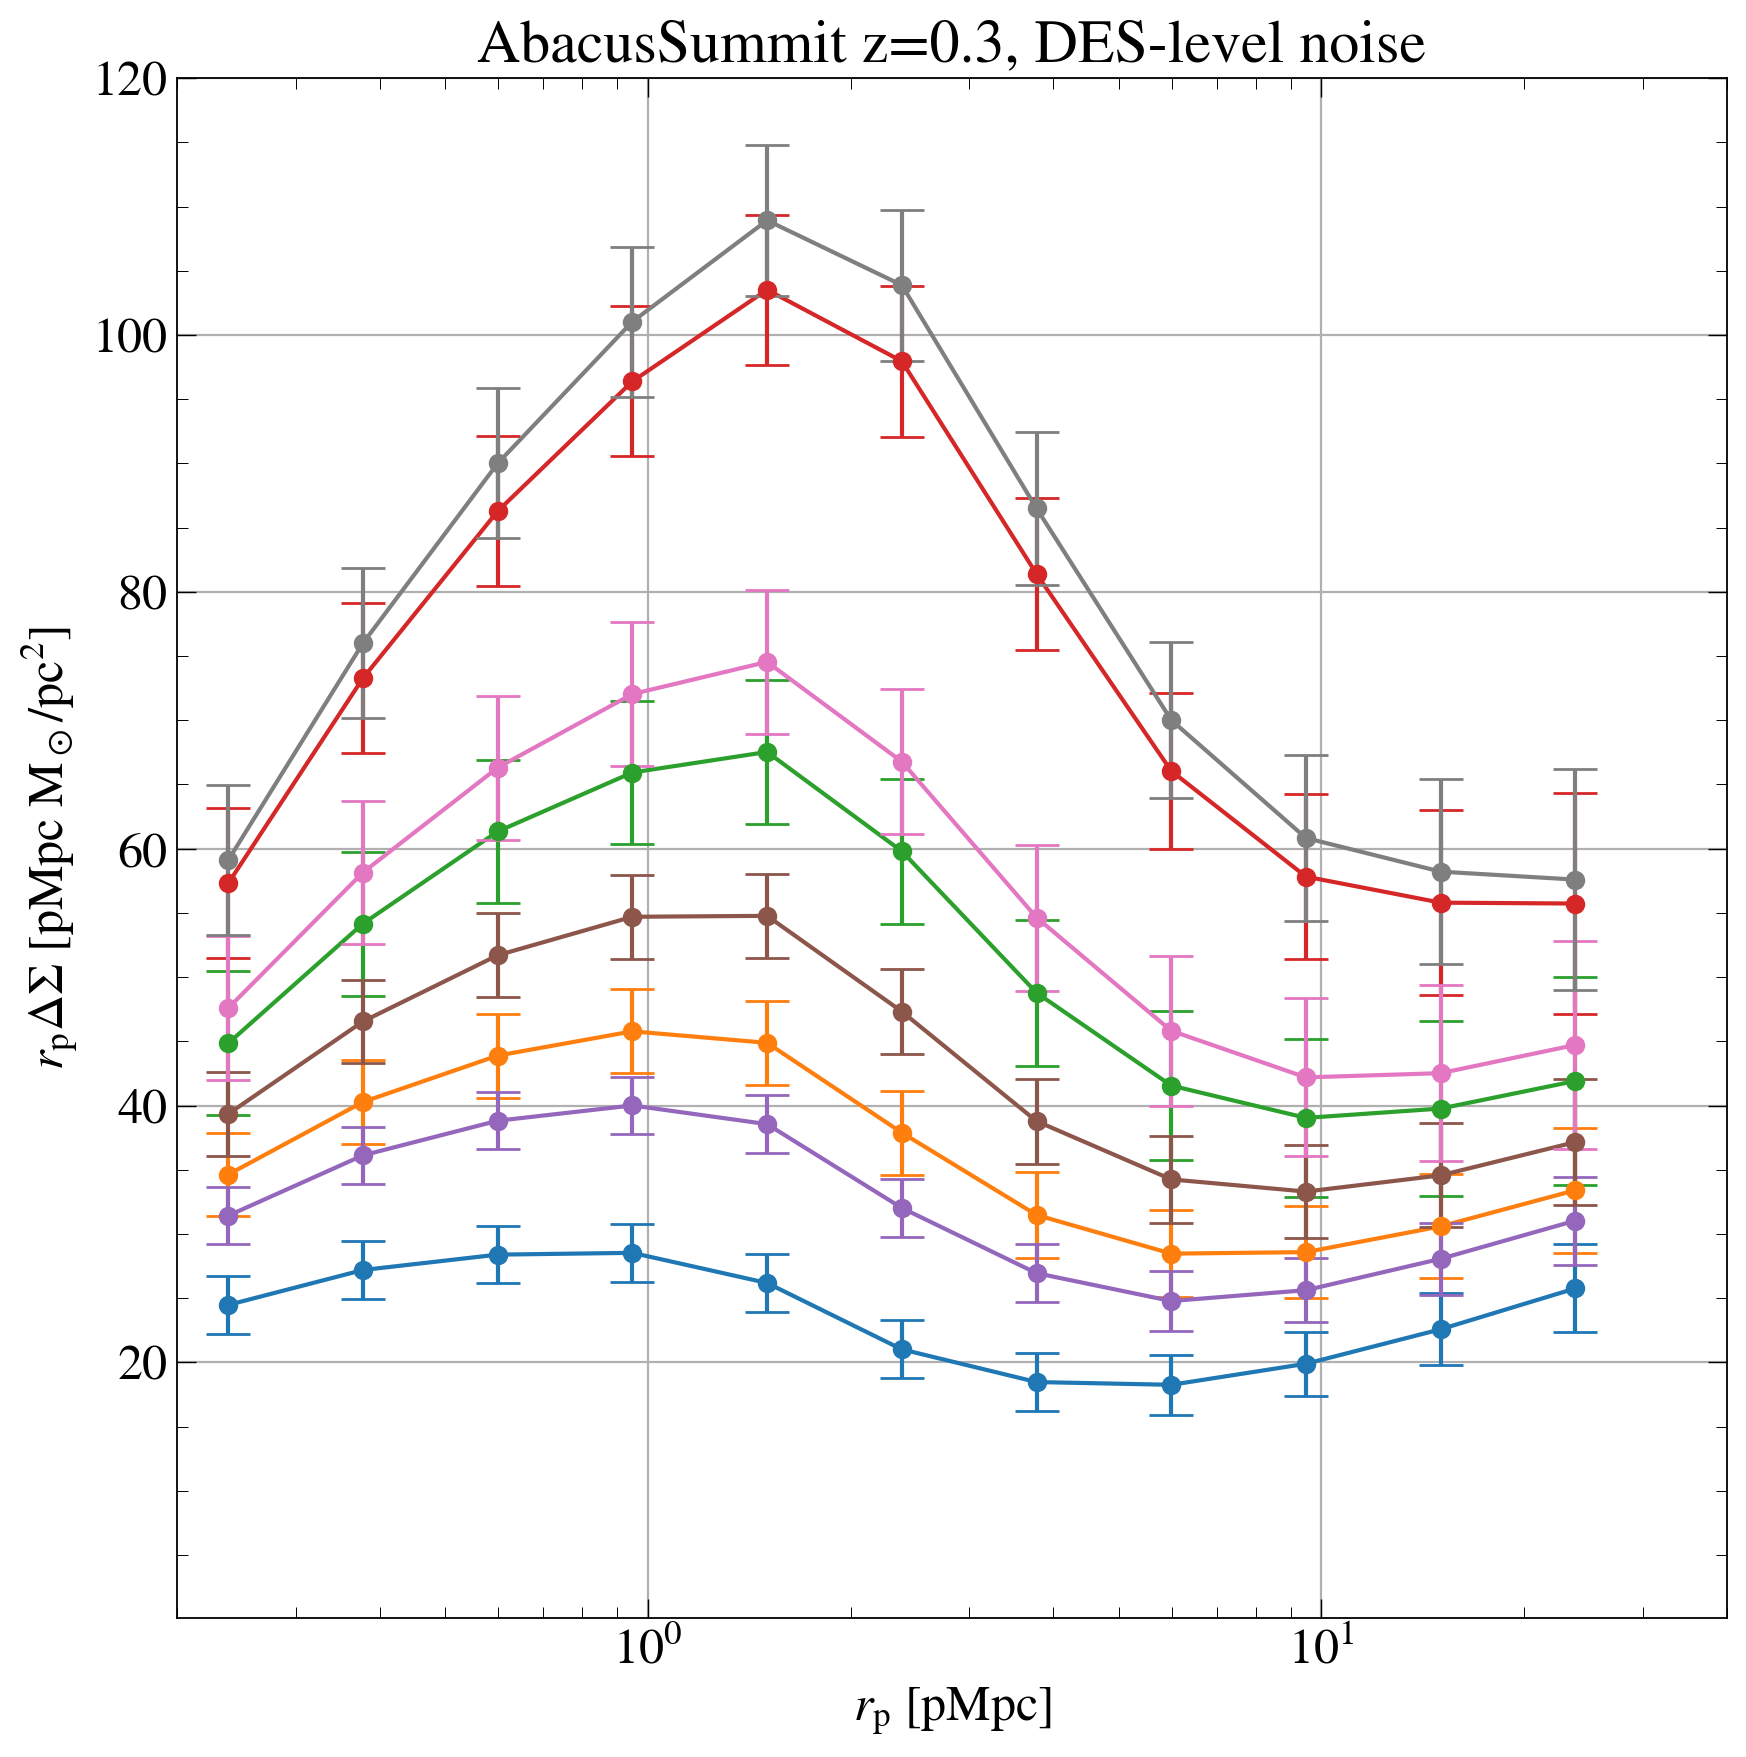

In [14]:
# plot the fake data and error bars
#plt.figure(figsize=(21,7))
plt.figure(figsize=(10,10))
cov_loc = '/users/hywu/work/cluster-lensing-cov-public/examples/abacus_summit_analytic/'
#for iz in [0]:#range(3):
    #plt.subplot(1,3,1+iz)
for binning in ['lam', 'abun']:
    
    redshift = z_sim[iz]
    data_loc = '/projects/hywu/cluster_sims/cluster_finding/data/emulator_data/base_c000_ph000/'
    data_loc += f'z{z_str}/model_hod000000/obs_q180_desy1/'

    for ilam in range(4):
        rp_in, DS_in = np.loadtxt(data_loc + f'DS_phys_noh_{binning}_bin_{ilam}.dat', unpack=True)
        DS_interp = interp1d(np.log(rp_in), np.log(DS_in))
        DS_data = np.exp(DS_interp(np.log(rp_rad)))
    
        cov = np.loadtxt(cov_loc + f'DeltaSigma_cov_combined_phys_noh_{z_data[iz]}_{z_data[iz+1]}_{lam[ilam]}_{lam[ilam+1]}.dat')
        sig = np.sqrt(np.diag(cov))[4:]
        line = plt.plot(rp_rad, rp_rad*DS_data)
        co = line[0].get_c()
        plt.errorbar(rp_rad, rp_rad*DS_data, rp_rad*sig, 
                     label='data', c=co, marker='o', mec=co, ls='', capsize=8)#, np.diag(cov))
        plt.xscale('log')
        print('frac noise: DS', sig/DS_data)
    
    plt.xlim(0.2, 40)
    plt.ylim(0.10, 120)
    plt.title(f'AbacusSummit z={redshift}, DES-level noise')
    
    plt.xlabel(r'$r_{\rm p}~[{\rm pMpc}]$')
    plt.ylabel(r'$r_{\rm p} \Delta\Sigma~[{\rm pMpc ~M_\odot/pc^2} ]$')
    sig_NC = np.sqrt(np.diag(cov_NC))
    print('frac noise: NC',sig_NC/NC_data)
#plt.savefig(f'../../plots/emulator/abacus_summit_fid_lensing.pdf')